In [1]:
import itertools
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from utils.data_preparation import naive_bayes_preprocessing
from models.naive_bayes import NaiveBayes

/Users/jantiegges/.pyenv/versions/3.11.5/envs/a3-comp551/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Naive Bayes

In [2]:
processed_data = naive_bayes_preprocessing(
    remove_stopwords=True, 
    use_bigrams=False
)
X_train, y_train = processed_data['train']
X_val, y_val = processed_data['validation']
X_test, y_test = processed_data['test']

In [3]:
nb = NaiveBayes(
    alpha=1.0,
    fit_prior=True,
)
nb.fit(X_train, y_train)
predictions = nb.predict(X_test)
acc = nb.evaluate_acc(y_test, predictions)

In [4]:
print(f"Accuracy of Naive Bayes model: {acc:.4f}")

Accuracy of Naive Bayes model: 0.7945


## Grid Search

In [5]:
with open('out/nb_grid_search_results.pkl', 'rb') as handle:
    grid_search_results = pickle.load(handle)
print(grid_search_results.head())

   alpha  fit_prior  use_bigrams  remove_stopwords  val_accuracy
0    0.2      False         True              True        0.8355
1    0.5      False        False              True        0.8265
2    1.0      False        False              True        0.8265
3    0.1      False         True              True        0.8250
4    0.2       True         True              True        0.8215


## Results

Best params:
alpha                  0.2
fit_prior            False
use_bigrams           True
remove_stopwords      True
val_accuracy        0.8355
Name: 0, dtype: object
Test accuracy of Naive Bayes model: 0.8390
              precision    recall  f1-score   support

           0       0.84      0.92      0.88       581
           1       0.86      0.89      0.88       695
           2       0.74      0.65      0.69       159
           3       0.87      0.77      0.82       275
           4       0.82      0.80      0.81       224
           5       0.79      0.41      0.54        66

    accuracy                           0.84      2000
   macro avg       0.82      0.74      0.77      2000
weighted avg       0.84      0.84      0.83      2000



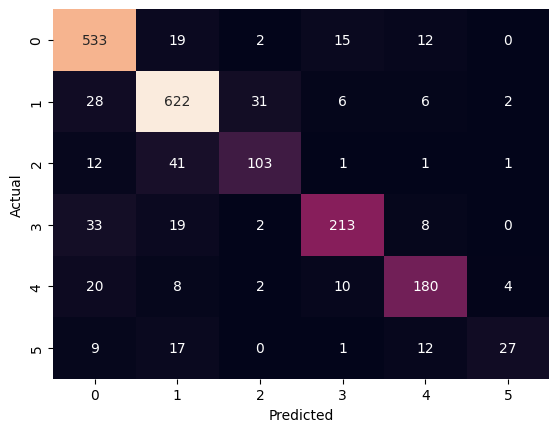

In [6]:
# take params from best model
best_params = grid_search_results.iloc[0]
print(f"Best params:\n{best_params}")

processed_data = naive_bayes_preprocessing(
    remove_stopwords=best_params['remove_stopwords'], 
    use_bigrams=best_params['use_bigrams']
)
X_train, y_train = processed_data['train']
X_test, y_test = processed_data['test']

nb = NaiveBayes(
    alpha=best_params['alpha'],
    fit_prior=best_params['fit_prior'],
)
nb.fit(X_train, y_train)
predictions = nb.predict(X_test)
test_acc = nb.evaluate_acc(y_test, predictions)
print(f"Test accuracy of Naive Bayes model: {test_acc:.4f}")

print(classification_report(y_test, predictions))
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()